In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F


In [13]:

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# MountainCar Deep Q-Learning
class MountainCarDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.95         # discount rate (gamma)
    network_sync_rate = 30000          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 100000       # size of replay memory
    mini_batch_size = 64            # size of the training data set sampled from the replay memory

    #num_divisions = 40

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.
 
    def plot_progress(self, rewards_per_episode, epsilon_history):
        plt.figure(1)
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        # plt.plot(sum_rewards)
        plt.plot(rewards_per_episode)

        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)

        plt.savefig('carpole_dql.png')


    def state_to_dqn_input(self, state)->torch.Tensor:
        # state_p = np.digitize(state[0], self.pos_space)
        # state_v = np.digitize(state[1], self.vel_space)
        # state_p1 = np.digitize(state[2], self.pos_space1)
        # state_v1 = np.digitize(state[3], self.vel_space1)

        #return torch.FloatTensor([state_p, state_v, state_p1, state_v1])
        return torch.FloatTensor(state)
    

    # Train the environment
    def train(self, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make('CartPole-v0', render_mode='human' if render else None)
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        #self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        #self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07
        #self.pos_space1 = np.linspace(env.observation_space.low[2], env.observation_space.high[2], self.num_divisions)    # Between -1.2 and 0.6
        #self.vel_space1 = np.linspace(env.observation_space.low[3], env.observation_space.high[3], self.num_divisions)
        
        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)


        policy_dqn = DQN(in_states=num_states, h1_nodes=40, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=40, out_actions=num_actions)

        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = []

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        goal_reached=False
        best_rewards=0

        for i in range(episodes):
            state = env.reset()[0]
            terminated = False  
            done_success = False
            rewards = 0

            while(not terminated and not done_success):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample()
                else:
                    # select best action
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                new_state, reward, terminated, done_success,_ = env.step(action)
                
                if terminated: # mistake
                    reward = -2
                if done_success:
                    reward = 2
                    
                # Accumulate reward
                rewards += reward

                # Save experience into memory
                memory.append((state, action, new_state, reward, done_success, terminated))

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            rewards_per_episode.append(rewards)
            
            if(done_success):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%500==0):
                print(f'Episode {i} Epsilon {epsilon}')
                self.plot_progress(rewards_per_episode, epsilon_history)
                torch.save(policy_dqn.state_dict(), f"carpole_dql_{i}.pt")                 # Save policy

            if rewards > best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')

                

            # Check if enough experience has been collected
            if len(memory) > self.mini_batch_size:# and goal_reached:
                #print('optimize Episode ', i)
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)



                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    print('sync Episode ', i)
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0
                    # Decay epsilon
                    epsilon = max(epsilon*0.99, 0.05)
                    epsilon_history.append(epsilon)
                    #self.mini_batch_size +=2

        # Close environment
        env.close()
        torch.save(policy_dqn.state_dict(), "carpole_dql_last.pt")

   
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, done_success, terminated in mini_batch:

            if done_success or terminated:
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state))
            
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



    # Run the environment with the learned policy
    def test(self, episodes, model_filepath):
        # Create FrozenLake instance
        env = gym.make('CartPole-v0', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        # self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        # self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07
        # self.pos_space1 = np.linspace(env.observation_space.low[2], env.observation_space.high[2], self.num_divisions)    # Between -1.2 and 0.6
        # self.vel_space1 = np.linspace(env.observation_space.low[3], env.observation_space.high[3], self.num_divisions)

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=40, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()    # switch model to evaluation mode

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                # Select best action
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)
            if truncated:
                print("win!")
        env.close()


In [14]:
mountaincar = MountainCarDQL()



Best rewards so far: 8.0
Best rewards so far: 13.0
Best rewards so far: 31.0
Best rewards so far: 32.0
Best rewards so far: 36.0
Best rewards so far: 53.0
Best rewards so far: 66.0
Best rewards so far: 69.0
Episode 500 Epsilon 1
Best rewards so far: 70.0
Best rewards so far: 71.0
Episode 1000 Epsilon 1
sync Episode  1349
Best rewards so far: 91.0
Episode 1500 Epsilon 0.99
Best rewards so far: 103.0
Episode 2000 Epsilon 0.99
Episode 2500 Epsilon 0.99
sync Episode  2662
Episode 3000 Epsilon 0.9801
Episode 3500 Epsilon 0.9801
sync Episode  3983
Episode 4000 Epsilon 0.9702989999999999
Episode 4500 Epsilon 0.9702989999999999
Episode 5000 Epsilon 0.9702989999999999
sync Episode  5287
Episode 5500 Epsilon 0.96059601
Best rewards so far: 106.0
Episode 6000 Epsilon 0.96059601
Episode 6500 Epsilon 0.96059601
sync Episode  6545
Episode 7000 Epsilon 0.9509900498999999
Episode 7500 Epsilon 0.9509900498999999
sync Episode  7769
Episode 8000 Epsilon 0.9414801494009999
Episode 8500 Epsilon 0.941480149

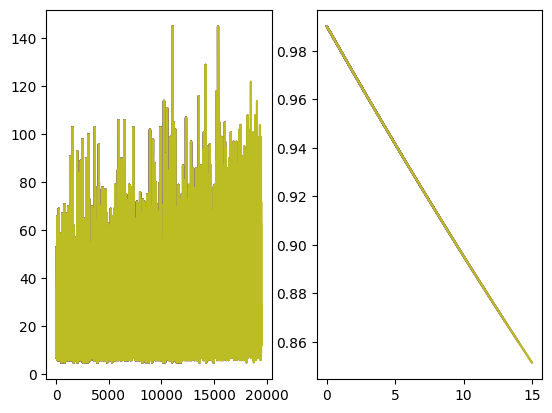

In [15]:
mountaincar.train(20000, False)

In [ ]:
mountaincar.test(5, 'carpole_dql_19500.pt')

win!
win!
win!
win!
